In [46]:
import xarray as xr
import matplotlib.pyplot as plt

import torch
from torch import nn
from torch import Tensor
import numpy as np
from tqdm import tqdm

import sys
sys.path.append('../')

from pytorch_utils.data_pipeline import TSData

## Data loder for a sequential model

* For the training loader, we use a window size of 100 time steps from the range 1980-01-01 to 2000-12-31
* For the validation loader, we use the entire sequence 2001-01-01 to 2020-12-31

In [47]:
ds = xr.open_zarr('../simple_sm_model/data/era5_40N6W.zarr').load()

train_loader = torch.utils.data.DataLoader(
    TSData(ds=ds, features=['et', 'tp'], targets='sm', time_slice=slice('1980', '2000'), return_seq=True, ts_window_size=365),
    batch_size=50,
    shuffle=True)
valid_loader = torch.utils.data.DataLoader(
    TSData(ds=ds, features=['et', 'tp'], targets='sm', time_slice=slice('2001', '2020'), return_seq=True, ts_window_size=-1, norm_stats=train_loader.dataset.norm_stats),
    batch_size=1,
    shuffle=False)

## We can iterate the data in batches of size 50

In [48]:
for i, (x, y) in enumerate(train_loader):
    print(x.shape, y.shape)

    if i > 3:
        break


torch.Size([50, 365, 2]) torch.Size([50, 365, 1])
torch.Size([50, 365, 2]) torch.Size([50, 365, 1])
torch.Size([50, 365, 2]) torch.Size([50, 365, 1])
torch.Size([50, 365, 2]) torch.Size([50, 365, 1])
torch.Size([50, 365, 2]) torch.Size([50, 365, 1])


In [49]:
class LSTM(nn.Module):
    def __init__(
            self,
            num_features: int,
            num_targets: int=1,
            num_hidden: int=8,
            learning_rate: float = 0.001,
            weight_decay: float = 0.0) -> None:
        """A fully connected feed-forward model.
        
        Parameters
        -----------
        num_features: int
            The number of input features.
        num_targets: int (default is 1)
            The number of targets.
        num_hidden: int (default is 8)
            The number of hidden nodes per layer.
        learning_rate: float (default is 0.001):
            The learning rate.
        weight_decay: float (default is 0.0)
            The weight decay (L2 regularization).
        """
        super().__init__()

        self.lstm = nn.LSTM(input_size=num_features, hidden_size=num_hidden, batch_first=True)
        self.linear = nn.Linear(in_features=num_hidden, out_features=num_targets)

        self.optimizer = self.get_optimizer(self.parameters(), learning_rate=learning_rate, weight_decay=weight_decay)

        self.loss_fn = nn.MSELoss()

    def forward(self, x: Tensor) -> Tensor:

        out, _ = self.lstm(x)
        out = self.linear(out)

        return out

    def train_epoch(self, train_loader: torch.utils.data.DataLoader) -> Tensor:
        self.train()

        loss_sum = torch.zeros(1)
        loss_counter = 0

        for x, y in train_loader:
            self.optimizer.zero_grad()

            y_hat = self(x)
            loss = self.loss_fn(y_hat, y)
            loss.backward()

            self.optimizer.step()

            loss_sum += loss.item()
            loss_counter += 1
        
        return (loss_sum / loss_counter).item()

    @torch.no_grad()
    def eval_epoch(self, valid_loader: torch.utils.data.DataLoader) -> Tensor:
        self.eval()

        loss_sum = torch.zeros(1)
        loss_counter = 0

        for x, y in valid_loader:

            y_hat = self(x)
            loss = self.loss_fn(y_hat, y)

        loss_sum += loss.item()
        loss_counter += 1

        return (loss_sum / loss_counter).item()

    def tune(self, num_epochs: int, train_loader: torch.utils.data.DataLoader, valid_loader: torch.utils.data.DataLoader) -> None:
        self.train_losses = np.zeros(num_epochs)
        self.valid_losses = np.zeros(num_epochs)

        train_loss = -1
        valid_loss = -1
        pbar = tqdm(range(num_epochs))
        for epoch in pbar:
            pbar.set_description(f'train loss: {train_loss:0.3f}, valid loss: {valid_loss:0.3f}')

            train_loss = self.train_epoch(train_loader=train_loader)
            valid_loss = self.eval_epoch(valid_loader=valid_loader)

            self.train_losses[epoch] = train_loss
            self.valid_losses[epoch] = valid_loss

    def get_optimizer(self, params: torch.ParameterDict, learning_rate: float = 0.001, weight_decay: float = 0.0) -> torch.optim.Optimizer:
        return torch.optim.AdamW(params, lr=learning_rate, weight_decay=weight_decay)


In [69]:
model = LSTM(num_features=2, learning_rate=0.01)

In [70]:
model.tune(num_epochs=20, train_loader=train_loader, valid_loader=valid_loader)

train loss: 0.421, valid loss: 0.714: 100%|██████████| 20/20 [03:21<00:00, 10.08s/it] 


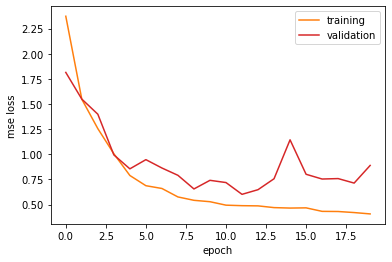

In [72]:
plt.plot(model.train_losses, label='training', color='tab:orange')
plt.plot(model.valid_losses, label='validation', color='tab:red')

plt.xlabel('epoch')
plt.ylabel('mse loss')

plt.legend()

In [73]:
batch_x, batch_y = next(iter(valid_loader))

In [74]:
batch_y_hat = model(batch_x)

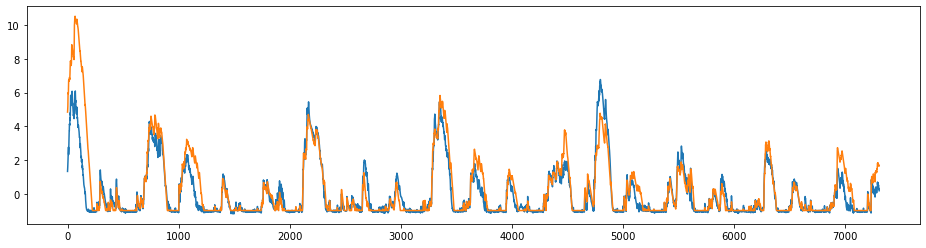

In [75]:
plt.figure(figsize=(16, 4))
plt.plot(batch_y_hat[0, :, 0].detach().numpy())
plt.plot(batch_y[0, :, 0].detach().numpy())

In [76]:
def compute_integrated_gradient(batch_x, batch_blank, model):
    mean_grad = 0
    n = 10

    for i in tqdm(range(1, n + 1)):
        x = batch_blank + i / n * (batch_x - batch_blank)
        x.requires_grad = True
        y = model(x)[0, -700, 0]
        (grad,) = torch.autograd.grad(y, x)
        mean_grad += grad / n

    integrated_gradients = (batch_x - batch_blank) * mean_grad

    return integrated_gradients, mean_grad

def compute_integrated_gradient_ts(batch_x, batch_blank, model):
    mean_grad = 0
    n = 10

    for i in tqdm(range(1, n + 1)):
        x = batch_blank + i / n * (batch_x - batch_blank)
        x.requires_grad = True
        y = model(x)[0, -700, 0]
        (grad,) = torch.autograd.grad(y, x)
        mean_grad += grad / n

    integrated_gradients = (batch_x - batch_blank) * mean_grad

    return integrated_gradients, mean_grad

In [88]:
batch_x_bl = torch.zeros_like(batch_x)
batch_x_bl[:, :, 0] = valid_loader.dataset.norm_np(batch_x_bl[:, :, 0], 'et')
batch_x_bl[:, :, 1] = valid_loader.dataset.norm_np(batch_x_bl[:, :, 1], 'tp')

In [89]:
intgrds = compute_integrated_gradient(batch_x, batch_x_bl, model)

100%|██████████| 10/10 [00:04<00:00,  2.36it/s]


In [90]:
it, mn = intgrds

In [91]:
batch_x_denorm = valid_loader.dataset.denorm_np(batch_x, 'sm')

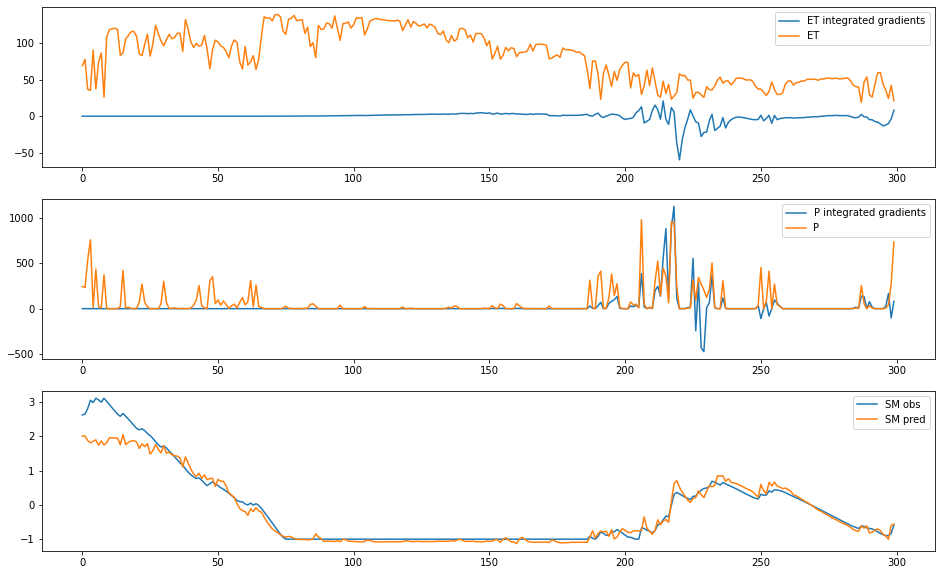

In [93]:
r = slice(-1000, -700)

fig, axes = plt.subplots(3, 1, figsize=(16, 10))
axes[0].plot(it[0, r, 0] * 1000, label='ET integrated gradients')
axes[0].plot(batch_x_denorm[0, r, 0], label='ET')

axes[1].plot(it[0, r, 1] * 5000, label='P integrated gradients')
axes[1].plot(batch_x_denorm[0, r, 1], label='P')

axes[2].plot(batch_y[0, r, 0], label='SM obs')
axes[2].plot(batch_y_hat[0, r, 0].detach().numpy(), label='SM pred')

axes[0].legend()
axes[1].legend()
axes[2].legend()
